In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar2=pd.read_csv('Solar 2.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar2['datetime']=pd.to_datetime(solar2['datetime'], format='%Y-%m-%d %H:%M:%S')
solar2= solar2.set_index('datetime')
solar2= solar2.asfreq('H')

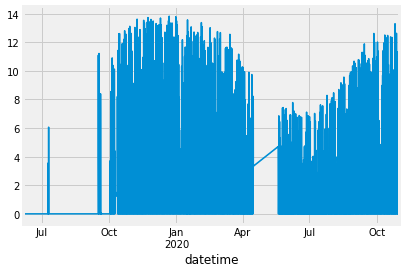

In [4]:
solar2['series_value'].plot()

In [6]:
#Split Train-Val for Solar2
# ==============================================================================
start_train='2019-10-01 00:00'
end_train='2020-04-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-08-01 00:00'
start_test='2020-08-01 01:00'

solar2train=solar2.loc[start_train:end_train, :]
solar2val=solar2.loc[start_val:end_val, :]
solar2test=solar2.loc[start_test:, :]

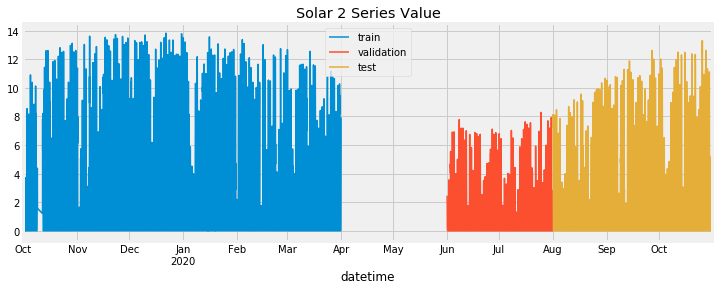

In [7]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar2train['series_value'].plot(ax=ax, label='train')
solar2val['series_value'].plot(ax=ax, label='validation')
solar2test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 2 Series Value')
ax.legend();

In [8]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:06:17 
Last fit date: None 
Skforecast version: 0.4.3 

In [9]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar2.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar2train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:10,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:05,  1.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:04,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:11<00:02,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:12<00:01,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:05,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:09,  1.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:11,  1.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:09,  1.56s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:06,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:08,  1.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:09,  1.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:06,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:02,  1.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:00,  1.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:56<00:00, 14.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.9235755442097333



In [10]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  2.923576   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  2.970937   
3   {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  3.085893   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  3.106860   
33  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  3.648636   
8   {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  3.682795   
6   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  3.688076   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  3.746287   
5   {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  3.802156   
18  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  3.812864   

    learning_rate  max_depth  n_estimators  
27           0.01        5.0         500.0  
29           0.01       10.0         500.0  
3            0.01        5.0         500.0  
32           0.10        5.0         100.0  
33           0.10        5.0         500.0  
8            0.10        5.0         100.0  
6            0.10        3.0         100.0  
30           0.10        3.0         100.0  
5            0.01       10.0         500.0  
18           0.10        3.0         100.0

In [11]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar2['series_value'],
    initial_train_size = len(solar2.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 2.5829897216203226


In [12]:
# Predictions
# ==============================================================================
predictions

pred
2020-08-01 01:00:00  5.117449
2020-08-01 02:00:00  5.410237
2020-08-01 03:00:00  6.058505
2020-08-01 04:00:00  5.499020
2020-08-01 05:00:00  3.194160
...                       ...
2020-10-31 19:00:00  0.082009
2020-10-31 20:00:00  0.794530
2020-10-31 21:00:00  2.189182
2020-10-31 22:00:00  2.884887
2020-10-31 23:00:00  4.357361

[2207 rows x 1 columns]

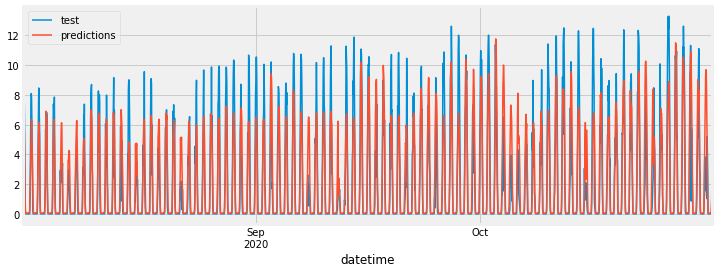

In [13]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar2test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [14]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [15]:
solar2test=solar2test.dropna()
solar2train=solar2train.dropna()

In [17]:
LGBM_Mase=mean_absolute_scaled_error(solar2test.reset_index()['series_value'],predictions.reset_index()['pred'],solar2train.reset_index()['series_value'])

In [18]:
# CatBoost Forecasting
# ==============================================================================

In [19]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x00000289B4058668> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-25 01:18:30 
Last fit date: None 
Skforecast version: 0.4.3 

In [20]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = solar2.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar2train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:08<01:36,  8.81s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:16<01:22,  8.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:23<01:08,  7.63s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:31<01:02,  7.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:45<01:09,  9.97s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:32<02:15, 22.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:39<01:27, 17.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:46<00:56, 14.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:53<00:35, 11.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [02:01<00:21, 10.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [02:16<00:11, 11.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:27,  7.93s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:16<01:25,  8.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:25<01:15,  8.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:37<01:19,  9.89s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [01:01<01:44, 14.88s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [02:35<04:10, 41.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [02:53<02:51, 34.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [03:20<02:07, 32.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [03:55<01:38, 32.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [04:39<01:12, 36.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [05:57<00:49, 49.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:11<02:02, 11.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:24<02:04, 12.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:36<01:50, 12.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:59<02:10, 16.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [01:53<03:29, 29.91s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [05:48<09:59, 99.92s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [06:08<06:08, 73.70s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [06:38<03:58, 59.75s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [07:11<02:34, 51.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [08:04<01:43, 51.76s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [10:19<01:17, 77.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:46<08:31, 46.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [01:40<08:31, 51.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [02:40<08:13, 54.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [03:38<07:28, 56.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [04:50<07:13, 62.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [06:45<08:00, 80.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [07:55<06:23, 76.70s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [09:10<05:04, 76.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [10:33<03:55, 78.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [12:02<02:43, 81.63s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [13:43<01:27, 87.60s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [45:39<00:00, 684.94s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.677494148995945



In [22]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = solar2['series_value'],
    initial_train_size = len(solar2.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 2.619567019882992


In [23]:
CatBoost_MASE=mean_absolute_scaled_error(solar2test.reset_index()['series_value'],cat_predictions.reset_index()['pred'],solar2train.reset_index()['series_value'])

In [24]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [25]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = solar2.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar2train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:05<01:04,  5.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:12<01:04,  6.43s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:18<00:57,  6.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:25<00:52,  6.60s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:32<00:45,  6.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:40<00:43,  7.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:46<00:33,  6.76s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:53<00:27,  6.77s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:59<00:19,  6.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:06<00:13,  6.81s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:13<00:06,  6.69s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:05<01:05,  5.95s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:14<01:15,  7.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:21<01:05,  7.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:30<01:04,  8.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:38<00:55,  7.98s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:50<00:56,  9.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:57<00:42,  8.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:04<00:32,  8.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:11<00:23,  7.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:19<00:15,  7.79s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:26<00:07,  7.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:17,  7.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:14<01:14,  7.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:21<01:05,  7.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:31<01:05,  8.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:39<00:57,  8.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:54<01:02, 10.42s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:01<00:46,  9.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:10<00:37,  9.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:18<00:26,  8.73s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:28<00:18,  9.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:36<00:08,  8.91s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:06<01:13,  6.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:13<01:09,  6.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:20<01:01,  6.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:28<00:58,  7.37s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:35<00:49,  7.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:44<00:47,  7.97s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:51<00:37,  7.57s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:58<00:29,  7.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:05<00:21,  7.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:13<00:14,  7.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:20<00:07,  7.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4393
Number of observations used for backtesting: 5746
    Number of folds: 160
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-05 15:00:00 -- 2019-12-07 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-07 03:00:00 -- 2019-12-08 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-08 15:00:00 -- 2019-12-10 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-10 03:00:00 -- 2019-12-11 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-12-05 14:00:00
    Validation: 2019-12-11 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [06:12<00:00, 93.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2.8571998350399994



In [26]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = solar2['series_value'],
    initial_train_size = len(solar2.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 2.626331527475869


In [27]:
XGB_MASE=mean_absolute_scaled_error(solar2test.reset_index()['series_value'],XGB_predictions.reset_index()['pred'],solar2train.reset_index()['series_value'])

In [28]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('s2_actual_additive.csv')

In [29]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [30]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test:, :]

In [31]:
prophet=prophet.dropna()

In [32]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:07,  1.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:08,  1.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:07,  1.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:08,  1.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:06,  1.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:07,  1.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:08<00:02,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:10<00:00,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:08,  1.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:07,  1.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:09,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:09,  1.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:04,  1.19s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:03,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:11<00:02,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:00,  1.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:08,  1.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:09,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:09<00:12,  2.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:10<00:07,  1.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:11<00:06,  1.62s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:12<00:04,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:14<00:02,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:15<00:01,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:05,  1.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:06,  1.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:05,  1.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:07,  1.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:05,  1.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:06,  1.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:04,  1.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:06<00:03,  1.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:07<00:02,  1.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:08<00:01,  1.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:08<00:00,  1.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:53<00:00, 13.48s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.9710575533295014



In [33]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
25  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.971058   
25  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.973540   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  2.004291   
13  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  2.111214   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  2.160985   
15  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  2.325595   
18  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  2.337823   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  2.473565   
17  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  2.505072   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  2.522929   

    learning_rate  max_depth  n_estimators  
27           0.01        5.0         500.0  
25           0.01        3.0         500.0  
29           0.01       10.0         500.0  
13           0.01        3.0         500.0  
30           0.10        3.0         100.0  
15           0.01        5.0         500.0  
18           0.10        3.0         100.0  
32           0.10        5.0         100.0  
17           0.01       10.0         500.0  
34           0.10       10.0         100.0

In [34]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 2.6351751650078534


In [35]:
# Predictions
# ==============================================================================
prophet_predictions

pred
2020-08-01 01:00:00  1.711700
2020-08-01 02:00:00  2.365648
2020-08-01 03:00:00  3.285285
2020-08-01 04:00:00  2.595359
2020-08-01 05:00:00  1.967937
...                       ...
2020-10-31 19:00:00  1.623094
2020-10-31 20:00:00  1.957276
2020-10-31 21:00:00  2.889046
2020-10-31 22:00:00  3.142640
2020-10-31 23:00:00  3.965835

[2207 rows x 1 columns]

In [36]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [37]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [38]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [39]:
LightGBM_Prophet_MASE

2.7937912437437618

In [40]:
LGBM_Mase

0.8782793976195418

In [41]:
CatBoost_MASE

0.8669411092929983

In [42]:
XGB_MASE

0.8769561353659389